# Architektur Neuronales Netz, Output x_H2 und x_NH3

In [1]:
# aNN Architektur

# Importe / Bibliotheken
import torch
from torch import nn
from torch.nn.functional import normalize as norm
from torch import log10
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR, MultiStepLR, ReduceLROnPlateau
from sklearn.metrics import r2_score as r2
from sklearn.metrics import max_error
# from sklearn.metrics import mean_squared_error as MSE
# from sklearn.metrics import mean_absolute_error as MAE
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

#### Default Datentyp

In [2]:
torch.set_default_dtype(torch.float64)

#### Erzeugnung des Moduls

In [3]:
class NeuralNetwork(nn.Module):
    
    #Initalisierung der Netzwerk layers
    def __init__(self, input_size, hidden1_size, hidden2_size, hidden3_size, output_size):
    
        super().__init__() #Referenz zur Base Class (nn.Module)
        #Kaskade der Layer
        self.linear_afunc_stack = nn.Sequential(
            #nn.BatchNorm1d(input_size), # Normalisierung, damit Inputdaten gleiche Größenordnung haben
            nn.Linear(input_size, hidden1_size), #Lineare Transformation mit gespeicherten weights und biases
            nn.ReLU(), #Nicht lineare Aktivierungsfunktion um komplexe nichtlineare Zusammenhänge abzubilden
            nn.Linear(hidden1_size, hidden2_size),
            nn.ReLU(),
            nn.Linear(hidden2_size, hidden3_size),
            nn.ReLU(),
            nn.Linear(hidden3_size, output_size),
        )

    #Implementierung der Operationen auf Input Daten
    def forward(self, x):
        out = self.linear_afunc_stack(x)
        return out

#### Ausgabe Modul

In [4]:
model = NeuralNetwork(5, 200, 200, 200, 2)
print(model)

NeuralNetwork(
  (linear_afunc_stack): Sequential(
    (0): Linear(in_features=5, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=200, bias=True)
    (3): ReLU()
    (4): Linear(in_features=200, out_features=200, bias=True)
    (5): ReLU()
    (6): Linear(in_features=200, out_features=2, bias=True)
  )
)


#### DataLoader

In [5]:
batch_size = 64 #Zahl der Datenpaare die vor einem erneuten Update der Parameter ins Netzt gegeben werden
eq_data_file = Path.cwd() / 'data' / 'eq_dataset_x.npz' #Import der GGW Daten

res = np.load(eq_data_file)

# Bei Speicherung wurden Daten als T, p, x_0 und xi gespeichert
# Inputs T, p, x_0[H2,N2,NH3]
# Outputs x[H2,N2,NH3]
# Umwandlen der np.arrays in torch.tensors zur besseren Arbeit mit PyTorch
T = torch.tensor(res['T'])
p = torch.tensor(res['p'])
x_0 = torch.tensor(res['x_0'])
x = torch.tensor(res['x'])

#Anpassen der Daten auf gleiche Größenordnung
#T = log10(T)
# T = T / 850
# p = p / 1000


# print(T.dtype)
# print(xi.dtype)

x_input = torch.stack((T, p ,x_0[:,0],x_0[:,1],x_0[:,2]),1)
y_output = torch.stack((x[:,0], x[:,2]), 1) # [H2, NH3], dritter Stoffmengenanteil ergibt sich den anderen
#print(x_input.size())
# print(xi.size())

# Split des Datensatzes in Trainings und Testdaten
split = 0.8 # Anteil Trainingsdaten

x_input_train = x_input[:int(split * len(x_input)), :]
y_output_train = y_output[:int(split * len(y_output)), :]
x_input_test = x_input[int(split * len(x_input)):, :]
y_output_test = y_output[int(split * len(y_output)):, :]

# Preprocessing Normalisierung der Daten
mean_in = torch.mean(x_input_train,0) # Mittelwert
std_in = torch.std(x_input_train,0) # Standardabweichung
mean_out = torch.mean(y_output_train,0)
std_out = torch.std(y_output_train,0)

x_input_train_norm = (x_input_train - mean_in) / std_in
y_output_train_norm = (y_output_train - mean_out) / std_out

x_input_test_norm = (x_input_test - mean_in) / std_in
y_output_test_norm = (y_output_test - mean_out) / std_out

# print(x_input_train_norm)
# print(torch.mean(x_input_train_norm[:,0]))

# Tensoren zu einem großen Set gruppieren
train_dataset = TensorDataset(x_input_train_norm, y_output_train_norm)
test_dataset = TensorDataset(x_input_test_norm, y_output_test_norm)
    
# # Split in Trainings und Test Set
# train_dataset, test_dataset = random_split(dataset, 
#                                            [int(0.8*len(dataset)), int(0.2*len(dataset))], # splitting 80/20
#                                            generator = torch.Generator().manual_seed(42)) # Festlegung seed zur Reproduktivität

# Erzeugen der DataLoader zur Arbeit mit Daten
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle=True) # shuffle batches zur Reduzierung von overfitting
test_dataloader = DataLoader(test_dataset, batch_size = batch_size, shuffle=False)


#### Generierung Netzwerk, Festlegung von loss Funktion und Optimizer

In [6]:
# Erzeugung aNN
net = NeuralNetwork(5, 200, 200, 200, 2)

# Loss Funktion; gibt Fehler an
#loss_fn = nn.MSELoss()
loss_fn = nn.L1Loss()

#Definition custom loss Funktion, MRE
def MRELoss(outputs, targets):
    
    loss = torch.mean(abs((outputs - targets) / targets))
    
    return loss
    

#Optimizer
learning_rate = 1e-2
optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate)
#scheduler = StepLR(optimizer, step_size = 30, gamma = 0.1)
#scheduler = MultiStepLR(optimizer, milestones=[30, 70, 100], gamma = 0.1)
scheduler = ReduceLROnPlateau(optimizer, factor = 0.1, patience = 10, threshold = 1e-4)

In [7]:
# learning_rate = 1e-6
# optimizer = torch.optim.Adam(net.parameters(), lr = learning_rate, )

#### Funktion zur Bestimmung der Genauigkeit

In [8]:
def check_accuracy(loader, net):
    
    loss = 0
    MRE = 0
    MAE = 0
    train_correct = 0
    train_total = len(loader.dataset)
    num_batches = len(loader) 
    #train_total = 0
    
    net.eval() # Put network in evaluation mode
    
    if loader == train_dataloader:
        dataset = "Train"
    else:
        dataset = "Test"
    
    with torch.no_grad():
        for X, y in loader:
            pred = net(X)
           
            #loss += MRELoss(pred, y).item()
            loss += loss_fn(pred, y) # Calculate the loss
            MRE += MRELoss(pred * std_out + mean_out, y * std_out + mean_out)
            MAE += loss_fn(pred * std_out + mean_out, y * std_out + mean_out)
            
            # Record the correct predictions for training data
            #_, predictions = torch.max(pred.data, 1)
            for i in range(len(pred)):
                if ((pred[i,0] * std_out[0] + mean_out[0]) - (y[i,0] * std_out[0] + mean_out[0]) and (pred[i,1] * std_out[1] + mean_out[1]) - (y[i,1] * std_out[1] + mean_out[1])) <= 0.01:
                    train_correct += 1
            #train_correct += (abs(pred.argmax(1) - y) <= 0.01).sum().item()
            #train_correct += (abs(predictions - y.data) <= 0.01).sum()
            #train_total += predictions.size(0)
            
        # Genauigkeit berechnen
        acc = float(train_correct) / float(train_total) * 100
        acc = round(acc, 2)
        
        loss /= num_batches
        MRE /= num_batches
        MAE /= num_batches

        print(f"{dataset} Error: \n Accuracy: {acc}%, Avg loss: {loss:>8f}, MRE: {MRE:>8f}, MAE: {MAE:>8f} \n")

    net.train()
    
    return acc, loss, MRE, MAE

#### Training

In [9]:
num_epochs = 200 #Iterationen über Datenset

train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []
train_MRE = []
test_MRE = []
train_MAE = []
test_MAE = []

#Optimierungsloop
for epoch in range(num_epochs):
#     train_correct = 0
#     train_total = 0
        
    for batch, (X,y) in enumerate(train_dataloader):
        
#         print(X.shape)
#         print(X.dtype)
        
        net.train() #Trainingmodus
        
        # forward
        pred = net(X)  # Do the forward pass
        loss = loss_fn(pred, y) # Calculate the loss
        #loss = MRELoss(pred, y)
        
        # backward
        optimizer.zero_grad() # Clear off the gradients from any past operation
        loss.backward()       # Calculate the gradients with help of back propagation, updating weights and biases
        
        # adam step gradient descent
        optimizer.step()      # Ask the optimizer to adjust the parameters based on the gradients  

        print ('Epoch %d/%d, Iteration %d/%d, Loss: %.4f' 
               %(epoch+1, num_epochs, batch+1, len(train_dataset)//batch_size, loss.item()))
        
    
    #scheduler.step() # Reduzieren Learning Rate (falls step size erreicht)
    net.eval() # Put the network into evaluation mode
    
    # Book keeping    
    # What was our train accuracy?
    tr_acc, tr_loss, tr_MRE, tr_MAE = check_accuracy(train_dataloader, net)
    
    #Record loss and accuracy
    train_accuracy.append(tr_acc)
    train_loss.append(tr_loss)
    train_MRE.append(tr_MRE)
    train_MAE.append(tr_MAE)
    
    scheduler.step(tr_loss) # LR scheduler step für reduceonPlateau
    
    # How did we do on the test set (the unseen set)
    # Record the correct predictions for test data
    t_acc, t_loss, t_MRE, t_MAE = check_accuracy(test_dataloader, net)
    test_accuracy.append(t_acc)
    test_loss.append(t_loss)
    test_MRE.append(t_MRE)
    test_MAE.append(t_MAE)

Epoch 1/200, Iteration 1/12, Loss: 0.8545
Epoch 1/200, Iteration 2/12, Loss: 0.5836
Epoch 1/200, Iteration 3/12, Loss: 0.5142
Epoch 1/200, Iteration 4/12, Loss: 0.3035
Epoch 1/200, Iteration 5/12, Loss: 0.4935
Epoch 1/200, Iteration 6/12, Loss: 0.3570
Epoch 1/200, Iteration 7/12, Loss: 0.2681
Epoch 1/200, Iteration 8/12, Loss: 0.2646
Epoch 1/200, Iteration 9/12, Loss: 0.2634
Epoch 1/200, Iteration 10/12, Loss: 0.2472
Epoch 1/200, Iteration 11/12, Loss: 0.2640
Epoch 1/200, Iteration 12/12, Loss: 0.3434
Epoch 1/200, Iteration 13/12, Loss: 0.2129
Train Error: 
 Accuracy: 84.12%, Avg loss: 0.229209, MRE: 0.154122, MAE: 0.029787 

Test Error: 
 Accuracy: 81.5%, Avg loss: 0.214933, MRE: 0.123138, MAE: 0.027840 

Epoch 2/200, Iteration 1/12, Loss: 0.1931
Epoch 2/200, Iteration 2/12, Loss: 0.3331
Epoch 2/200, Iteration 3/12, Loss: 0.3064
Epoch 2/200, Iteration 4/12, Loss: 0.2415
Epoch 2/200, Iteration 5/12, Loss: 0.2310
Epoch 2/200, Iteration 6/12, Loss: 0.2302
Epoch 2/200, Iteration 7/12, Los

Train Error: 
 Accuracy: 94.38%, Avg loss: 0.067178, MRE: 0.046261, MAE: 0.009221 

Test Error: 
 Accuracy: 94.0%, Avg loss: 0.063113, MRE: 0.038753, MAE: 0.008645 

Epoch 13/200, Iteration 1/12, Loss: 0.0701
Epoch 13/200, Iteration 2/12, Loss: 0.0665
Epoch 13/200, Iteration 3/12, Loss: 0.0618
Epoch 13/200, Iteration 4/12, Loss: 0.0904
Epoch 13/200, Iteration 5/12, Loss: 0.0626
Epoch 13/200, Iteration 6/12, Loss: 0.0640
Epoch 13/200, Iteration 7/12, Loss: 0.0853
Epoch 13/200, Iteration 8/12, Loss: 0.0616
Epoch 13/200, Iteration 9/12, Loss: 0.0735
Epoch 13/200, Iteration 10/12, Loss: 0.0866
Epoch 13/200, Iteration 11/12, Loss: 0.0861
Epoch 13/200, Iteration 12/12, Loss: 0.0837
Epoch 13/200, Iteration 13/12, Loss: 0.0627
Train Error: 
 Accuracy: 87.75%, Avg loss: 0.076446, MRE: 0.071223, MAE: 0.010060 

Test Error: 
 Accuracy: 92.0%, Avg loss: 0.064461, MRE: 0.054140, MAE: 0.008580 

Epoch 14/200, Iteration 1/12, Loss: 0.0767
Epoch 14/200, Iteration 2/12, Loss: 0.0749
Epoch 14/200, Itera

Train Error: 
 Accuracy: 98.0%, Avg loss: 0.062957, MRE: 0.046358, MAE: 0.008655 

Test Error: 
 Accuracy: 98.0%, Avg loss: 0.059524, MRE: 0.040349, MAE: 0.007947 

Epoch 25/200, Iteration 1/12, Loss: 0.0609
Epoch 25/200, Iteration 2/12, Loss: 0.0519
Epoch 25/200, Iteration 3/12, Loss: 0.0634
Epoch 25/200, Iteration 4/12, Loss: 0.0647
Epoch 25/200, Iteration 5/12, Loss: 0.0515
Epoch 25/200, Iteration 6/12, Loss: 0.0570
Epoch 25/200, Iteration 7/12, Loss: 0.0536
Epoch 25/200, Iteration 8/12, Loss: 0.0526
Epoch 25/200, Iteration 9/12, Loss: 0.0465
Epoch 25/200, Iteration 10/12, Loss: 0.0467
Epoch 25/200, Iteration 11/12, Loss: 0.0426
Epoch 25/200, Iteration 12/12, Loss: 0.0592
Epoch 25/200, Iteration 13/12, Loss: 0.0620
Train Error: 
 Accuracy: 98.5%, Avg loss: 0.046486, MRE: 0.032575, MAE: 0.005804 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.050250, MRE: 0.032277, MAE: 0.006267 

Epoch 26/200, Iteration 1/12, Loss: 0.0486
Epoch 26/200, Iteration 2/12, Loss: 0.0561
Epoch 26/200, Iterati

Train Error: 
 Accuracy: 99.62%, Avg loss: 0.013770, MRE: 0.013871, MAE: 0.001788 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.016189, MRE: 0.012340, MAE: 0.002193 

Epoch 37/200, Iteration 1/12, Loss: 0.0145
Epoch 37/200, Iteration 2/12, Loss: 0.0159
Epoch 37/200, Iteration 3/12, Loss: 0.0193
Epoch 37/200, Iteration 4/12, Loss: 0.0182
Epoch 37/200, Iteration 5/12, Loss: 0.0147
Epoch 37/200, Iteration 6/12, Loss: 0.0123
Epoch 37/200, Iteration 7/12, Loss: 0.0144
Epoch 37/200, Iteration 8/12, Loss: 0.0151
Epoch 37/200, Iteration 9/12, Loss: 0.0132
Epoch 37/200, Iteration 10/12, Loss: 0.0157
Epoch 37/200, Iteration 11/12, Loss: 0.0144
Epoch 37/200, Iteration 12/12, Loss: 0.0157
Epoch 37/200, Iteration 13/12, Loss: 0.0111
Train Error: 
 Accuracy: 99.62%, Avg loss: 0.012599, MRE: 0.013099, MAE: 0.001638 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.015102, MRE: 0.011084, MAE: 0.002030 

Epoch 38/200, Iteration 1/12, Loss: 0.0138
Epoch 38/200, Iteration 2/12, Loss: 0.0113
Epoch 38/200, Iter

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.010113, MRE: 0.010617, MAE: 0.001315 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.013577, MRE: 0.009751, MAE: 0.001812 

Epoch 49/200, Iteration 1/12, Loss: 0.0086
Epoch 49/200, Iteration 2/12, Loss: 0.0107
Epoch 49/200, Iteration 3/12, Loss: 0.0108
Epoch 49/200, Iteration 4/12, Loss: 0.0112
Epoch 49/200, Iteration 5/12, Loss: 0.0114
Epoch 49/200, Iteration 6/12, Loss: 0.0104
Epoch 49/200, Iteration 7/12, Loss: 0.0105
Epoch 49/200, Iteration 8/12, Loss: 0.0116
Epoch 49/200, Iteration 9/12, Loss: 0.0116
Epoch 49/200, Iteration 10/12, Loss: 0.0092
Epoch 49/200, Iteration 11/12, Loss: 0.0107
Epoch 49/200, Iteration 12/12, Loss: 0.0084
Epoch 49/200, Iteration 13/12, Loss: 0.0096
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.010633, MRE: 0.011207, MAE: 0.001478 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.014165, MRE: 0.009586, MAE: 0.001974 

Epoch 50/200, Iteration 1/12, Loss: 0.0122
Epoch 50/200, Iteration 2/12, Loss: 0.0120
Epoch 50/200, Itera

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.009136, MRE: 0.009857, MAE: 0.001201 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012561, MRE: 0.008752, MAE: 0.001646 

Epoch 61/200, Iteration 1/12, Loss: 0.0086
Epoch 61/200, Iteration 2/12, Loss: 0.0089
Epoch 61/200, Iteration 3/12, Loss: 0.0080
Epoch 61/200, Iteration 4/12, Loss: 0.0086
Epoch 61/200, Iteration 5/12, Loss: 0.0078
Epoch 61/200, Iteration 6/12, Loss: 0.0089
Epoch 61/200, Iteration 7/12, Loss: 0.0101
Epoch 61/200, Iteration 8/12, Loss: 0.0086
Epoch 61/200, Iteration 9/12, Loss: 0.0150
Epoch 61/200, Iteration 10/12, Loss: 0.0076
Epoch 61/200, Iteration 11/12, Loss: 0.0080
Epoch 61/200, Iteration 12/12, Loss: 0.0071
Epoch 61/200, Iteration 13/12, Loss: 0.0126
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008713, MRE: 0.010034, MAE: 0.001144 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.011735, MRE: 0.008333, MAE: 0.001540 

Epoch 62/200, Iteration 1/12, Loss: 0.0088
Epoch 62/200, Iteration 2/12, Loss: 0.0082
Epoch 62/200, Ite

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.008612, MRE: 0.009132, MAE: 0.001113 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012548, MRE: 0.008136, MAE: 0.001630 

Epoch 73/200, Iteration 1/12, Loss: 0.0087
Epoch 73/200, Iteration 2/12, Loss: 0.0103
Epoch 73/200, Iteration 3/12, Loss: 0.0097
Epoch 73/200, Iteration 4/12, Loss: 0.0071
Epoch 73/200, Iteration 5/12, Loss: 0.0081
Epoch 73/200, Iteration 6/12, Loss: 0.0119
Epoch 73/200, Iteration 7/12, Loss: 0.0067
Epoch 73/200, Iteration 8/12, Loss: 0.0101
Epoch 73/200, Iteration 9/12, Loss: 0.0073
Epoch 73/200, Iteration 10/12, Loss: 0.0073
Epoch 73/200, Iteration 11/12, Loss: 0.0092
Epoch 73/200, Iteration 12/12, Loss: 0.0106
Epoch 73/200, Iteration 13/12, Loss: 0.0108
Train Error: 
 Accuracy: 99.75%, Avg loss: 0.010996, MRE: 0.009778, MAE: 0.001454 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.012803, MRE: 0.008060, MAE: 0.001698 

Epoch 74/200, Iteration 1/12, Loss: 0.0108
Epoch 74/200, Iteration 2/12, Loss: 0.0128
Epoch 74/200, Ite

Train Error: 
 Accuracy: 99.75%, Avg loss: 0.008265, MRE: 0.008001, MAE: 0.001093 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.011214, MRE: 0.007557, MAE: 0.001488 

Epoch 85/200, Iteration 1/12, Loss: 0.0069
Epoch 85/200, Iteration 2/12, Loss: 0.0123
Epoch 85/200, Iteration 3/12, Loss: 0.0099
Epoch 85/200, Iteration 4/12, Loss: 0.0073
Epoch 85/200, Iteration 5/12, Loss: 0.0092
Epoch 85/200, Iteration 6/12, Loss: 0.0074
Epoch 85/200, Iteration 7/12, Loss: 0.0070
Epoch 85/200, Iteration 8/12, Loss: 0.0084
Epoch 85/200, Iteration 9/12, Loss: 0.0085
Epoch 85/200, Iteration 10/12, Loss: 0.0081
Epoch 85/200, Iteration 11/12, Loss: 0.0095
Epoch 85/200, Iteration 12/12, Loss: 0.0090
Epoch 85/200, Iteration 13/12, Loss: 0.0065
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.008375, MRE: 0.008328, MAE: 0.001051 

Test Error: 
 Accuracy: 99.5%, Avg loss: 0.012214, MRE: 0.008421, MAE: 0.001592 

Epoch 86/200, Iteration 1/12, Loss: 0.0073
Epoch 86/200, Iteration 2/12, Loss: 0.0086
Epoch 86/200, Itera

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.009072, MRE: 0.005818, MAE: 0.001196 

Epoch 97/200, Iteration 1/12, Loss: 0.0042
Epoch 97/200, Iteration 2/12, Loss: 0.0041
Epoch 97/200, Iteration 3/12, Loss: 0.0044
Epoch 97/200, Iteration 4/12, Loss: 0.0039
Epoch 97/200, Iteration 5/12, Loss: 0.0049
Epoch 97/200, Iteration 6/12, Loss: 0.0048
Epoch 97/200, Iteration 7/12, Loss: 0.0047
Epoch 97/200, Iteration 8/12, Loss: 0.0048
Epoch 97/200, Iteration 9/12, Loss: 0.0054
Epoch 97/200, Iteration 10/12, Loss: 0.0049
Epoch 97/200, Iteration 11/12, Loss: 0.0038
Epoch 97/200, Iteration 12/12, Loss: 0.0042
Epoch 97/200, Iteration 13/12, Loss: 0.0045
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.004359, MRE: 0.005769, MAE: 0.000585 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008785, MRE: 0.005645, MAE: 0.001163 

Epoch 98/200, Iteration 1/12, Loss: 0.0044
Epoch 98/200, Iteration 2/12, Loss: 0.0039
Epoch 98/200, Iteration 3/12, Loss: 0.0047
Epoch 98/200, Iteration 4/12, Loss: 0.0040
Epoch 98/200, I

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008956, MRE: 0.005696, MAE: 0.001176 

Epoch 109/200, Iteration 1/12, Loss: 0.0053
Epoch 109/200, Iteration 2/12, Loss: 0.0042
Epoch 109/200, Iteration 3/12, Loss: 0.0048
Epoch 109/200, Iteration 4/12, Loss: 0.0039
Epoch 109/200, Iteration 5/12, Loss: 0.0042
Epoch 109/200, Iteration 6/12, Loss: 0.0044
Epoch 109/200, Iteration 7/12, Loss: 0.0045
Epoch 109/200, Iteration 8/12, Loss: 0.0035
Epoch 109/200, Iteration 9/12, Loss: 0.0040
Epoch 109/200, Iteration 10/12, Loss: 0.0035
Epoch 109/200, Iteration 11/12, Loss: 0.0043
Epoch 109/200, Iteration 12/12, Loss: 0.0035
Epoch 109/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.004202, MRE: 0.005398, MAE: 0.000573 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008949, MRE: 0.005642, MAE: 0.001186 

Epoch 110/200, Iteration 1/12, Loss: 0.0037
Epoch 110/200, Iteration 2/12, Loss: 0.0046
Epoch 110/200, Iteration 3/12, Loss: 0.0041
Epoch 110/200, Iteration 4/12, Loss: 0.004

Epoch 121/200, Iteration 3/12, Loss: 0.0037
Epoch 121/200, Iteration 4/12, Loss: 0.0034
Epoch 121/200, Iteration 5/12, Loss: 0.0039
Epoch 121/200, Iteration 6/12, Loss: 0.0043
Epoch 121/200, Iteration 7/12, Loss: 0.0038
Epoch 121/200, Iteration 8/12, Loss: 0.0035
Epoch 121/200, Iteration 9/12, Loss: 0.0033
Epoch 121/200, Iteration 10/12, Loss: 0.0046
Epoch 121/200, Iteration 11/12, Loss: 0.0044
Epoch 121/200, Iteration 12/12, Loss: 0.0038
Epoch 121/200, Iteration 13/12, Loss: 0.0032
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003830, MRE: 0.005148, MAE: 0.000518 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008769, MRE: 0.005538, MAE: 0.001152 

Epoch 122/200, Iteration 1/12, Loss: 0.0033
Epoch 122/200, Iteration 2/12, Loss: 0.0042
Epoch 122/200, Iteration 3/12, Loss: 0.0037
Epoch 122/200, Iteration 4/12, Loss: 0.0055
Epoch 122/200, Iteration 5/12, Loss: 0.0040
Epoch 122/200, Iteration 6/12, Loss: 0.0042
Epoch 122/200, Iteration 7/12, Loss: 0.0037
Epoch 122/200, Iteration 8/12, Loss: 

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003852, MRE: 0.005230, MAE: 0.000521 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008708, MRE: 0.005479, MAE: 0.001145 

Epoch 133/200, Iteration 1/12, Loss: 0.0043
Epoch 133/200, Iteration 2/12, Loss: 0.0040
Epoch 133/200, Iteration 3/12, Loss: 0.0037
Epoch 133/200, Iteration 4/12, Loss: 0.0042
Epoch 133/200, Iteration 5/12, Loss: 0.0037
Epoch 133/200, Iteration 6/12, Loss: 0.0045
Epoch 133/200, Iteration 7/12, Loss: 0.0033
Epoch 133/200, Iteration 8/12, Loss: 0.0041
Epoch 133/200, Iteration 9/12, Loss: 0.0042
Epoch 133/200, Iteration 10/12, Loss: 0.0038
Epoch 133/200, Iteration 11/12, Loss: 0.0032
Epoch 133/200, Iteration 12/12, Loss: 0.0049
Epoch 133/200, Iteration 13/12, Loss: 0.0030
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003918, MRE: 0.005076, MAE: 0.000522 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008804, MRE: 0.005500, MAE: 0.001158 

Epoch 134/200, Iteration 1/12, Loss: 0.0034
Epoch 134/200, Iteration 2/12, Loss: 0.0043
Ep

Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003737, MRE: 0.005148, MAE: 0.000508 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008727, MRE: 0.005450, MAE: 0.001149 

Epoch 145/200, Iteration 1/12, Loss: 0.0033
Epoch 145/200, Iteration 2/12, Loss: 0.0038
Epoch 145/200, Iteration 3/12, Loss: 0.0038
Epoch 145/200, Iteration 4/12, Loss: 0.0042
Epoch 145/200, Iteration 5/12, Loss: 0.0036
Epoch 145/200, Iteration 6/12, Loss: 0.0032
Epoch 145/200, Iteration 7/12, Loss: 0.0037
Epoch 145/200, Iteration 8/12, Loss: 0.0041
Epoch 145/200, Iteration 9/12, Loss: 0.0038
Epoch 145/200, Iteration 10/12, Loss: 0.0029
Epoch 145/200, Iteration 11/12, Loss: 0.0037
Epoch 145/200, Iteration 12/12, Loss: 0.0037
Epoch 145/200, Iteration 13/12, Loss: 0.0033
Train Error: 
 Accuracy: 99.88%, Avg loss: 0.003827, MRE: 0.005103, MAE: 0.000527 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008658, MRE: 0.005443, MAE: 0.001139 

Epoch 146/200, Iteration 1/12, Loss: 0.0038
Epoch 146/200, Iteration 2/12, Loss: 0.0048
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003431, MRE: 0.004766, MAE: 0.000464 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008642, MRE: 0.005394, MAE: 0.001138 

Epoch 157/200, Iteration 1/12, Loss: 0.0032
Epoch 157/200, Iteration 2/12, Loss: 0.0033
Epoch 157/200, Iteration 3/12, Loss: 0.0039
Epoch 157/200, Iteration 4/12, Loss: 0.0028
Epoch 157/200, Iteration 5/12, Loss: 0.0029
Epoch 157/200, Iteration 6/12, Loss: 0.0032
Epoch 157/200, Iteration 7/12, Loss: 0.0035
Epoch 157/200, Iteration 8/12, Loss: 0.0034
Epoch 157/200, Iteration 9/12, Loss: 0.0039
Epoch 157/200, Iteration 10/12, Loss: 0.0037
Epoch 157/200, Iteration 11/12, Loss: 0.0044
Epoch 157/200, Iteration 12/12, Loss: 0.0032
Epoch 157/200, Iteration 13/12, Loss: 0.0025
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003446, MRE: 0.004810, MAE: 0.000465 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008653, MRE: 0.005405, MAE: 0.001139 

Epoch 158/200, Iteration 1/12, Loss: 0.0033
Epoch 158/200, Iteration 2/12, Loss: 0.0031
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003367, MRE: 0.004761, MAE: 0.000459 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008646, MRE: 0.005400, MAE: 0.001139 

Epoch 169/200, Iteration 1/12, Loss: 0.0043
Epoch 169/200, Iteration 2/12, Loss: 0.0039
Epoch 169/200, Iteration 3/12, Loss: 0.0028
Epoch 169/200, Iteration 4/12, Loss: 0.0042
Epoch 169/200, Iteration 5/12, Loss: 0.0038
Epoch 169/200, Iteration 6/12, Loss: 0.0031
Epoch 169/200, Iteration 7/12, Loss: 0.0035
Epoch 169/200, Iteration 8/12, Loss: 0.0039
Epoch 169/200, Iteration 9/12, Loss: 0.0029
Epoch 169/200, Iteration 10/12, Loss: 0.0024
Epoch 169/200, Iteration 11/12, Loss: 0.0032
Epoch 169/200, Iteration 12/12, Loss: 0.0031
Epoch 169/200, Iteration 13/12, Loss: 0.0027
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003392, MRE: 0.004751, MAE: 0.000463 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008640, MRE: 0.005396, MAE: 0.001137 

Epoch 170/200, Iteration 1/12, Loss: 0.0031
Epoch 170/200, Iteration 2/12, Loss: 0.0038
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003370, MRE: 0.004711, MAE: 0.000458 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008636, MRE: 0.005393, MAE: 0.001137 

Epoch 181/200, Iteration 1/12, Loss: 0.0029
Epoch 181/200, Iteration 2/12, Loss: 0.0031
Epoch 181/200, Iteration 3/12, Loss: 0.0028
Epoch 181/200, Iteration 4/12, Loss: 0.0037
Epoch 181/200, Iteration 5/12, Loss: 0.0038
Epoch 181/200, Iteration 6/12, Loss: 0.0031
Epoch 181/200, Iteration 7/12, Loss: 0.0031
Epoch 181/200, Iteration 8/12, Loss: 0.0035
Epoch 181/200, Iteration 9/12, Loss: 0.0037
Epoch 181/200, Iteration 10/12, Loss: 0.0042
Epoch 181/200, Iteration 11/12, Loss: 0.0033
Epoch 181/200, Iteration 12/12, Loss: 0.0036
Epoch 181/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003349, MRE: 0.004732, MAE: 0.000457 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008631, MRE: 0.005395, MAE: 0.001137 

Epoch 182/200, Iteration 1/12, Loss: 0.0032
Epoch 182/200, Iteration 2/12, Loss: 0.0034
Ep

Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003337, MRE: 0.004686, MAE: 0.000455 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008651, MRE: 0.005392, MAE: 0.001138 

Epoch 193/200, Iteration 1/12, Loss: 0.0037
Epoch 193/200, Iteration 2/12, Loss: 0.0030
Epoch 193/200, Iteration 3/12, Loss: 0.0036
Epoch 193/200, Iteration 4/12, Loss: 0.0031
Epoch 193/200, Iteration 5/12, Loss: 0.0037
Epoch 193/200, Iteration 6/12, Loss: 0.0029
Epoch 193/200, Iteration 7/12, Loss: 0.0037
Epoch 193/200, Iteration 8/12, Loss: 0.0042
Epoch 193/200, Iteration 9/12, Loss: 0.0038
Epoch 193/200, Iteration 10/12, Loss: 0.0029
Epoch 193/200, Iteration 11/12, Loss: 0.0037
Epoch 193/200, Iteration 12/12, Loss: 0.0025
Epoch 193/200, Iteration 13/12, Loss: 0.0024
Train Error: 
 Accuracy: 100.0%, Avg loss: 0.003340, MRE: 0.004774, MAE: 0.000454 

Test Error: 
 Accuracy: 100.0%, Avg loss: 0.008617, MRE: 0.005389, MAE: 0.001135 

Epoch 194/200, Iteration 1/12, Loss: 0.0028
Epoch 194/200, Iteration 2/12, Loss: 0.0030
Ep

#### Plots loss vs Epoch

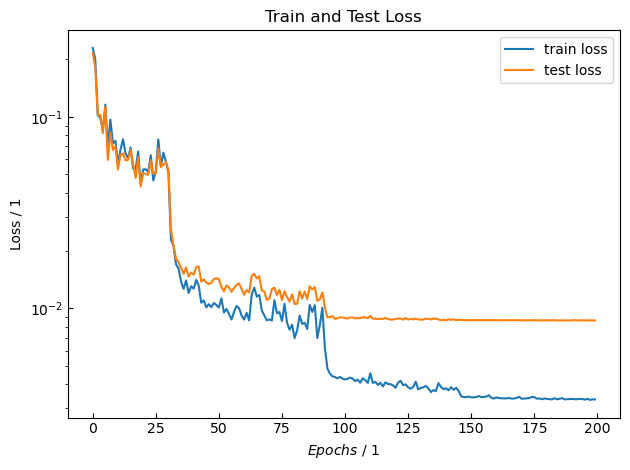

In [10]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.semilogy(train_loss, label='train loss')
ax.semilogy(test_loss, label='test loss')
plt.title("Train and Test Loss")
ax.set(xlabel = '$Epochs$ / 1', ylabel = 'Loss / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

In [11]:
#np.savez('data/models/hyperparams/loss_005_010.npz', train_loss = train_loss, test_loss = test_loss)

#### Parity Plot

Training Dataset: R^2(H2) = 0.9999691312893937 , R^2(NH3) = 0.9999456679461979
Test Dataset: R^2(H2) = 0.9998602835090684 , R^2(NH3) = 0.9998072854829589
Max Error Training: |x_H2 - x_H2,pred| = 0.01224540138411162 , |x_NH3 - x_NH3,pred| = 0.009946172255653224
Max Error Test: |x_H2 - x_H2,pred| = 0.009960553512023185 , |x_NH3 - x_NH3,pred| = 0.007910104122263395


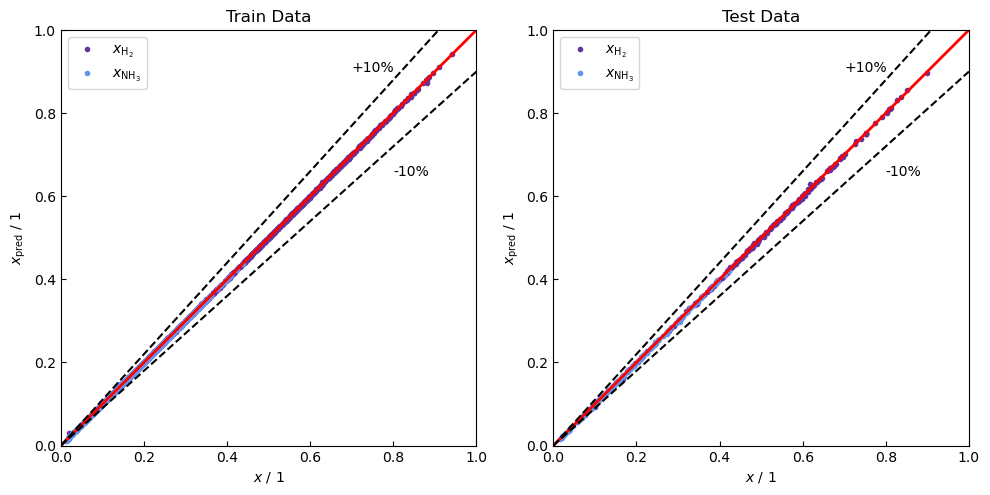

In [12]:
x_H2_real_norm = []
x_H2_pred_norm = []
x_NH3_real_norm = []
x_NH3_pred_norm = []
for (X,y) in train_dataloader:
    x_H2_real_norm = np.append(x_H2_real_norm, y[:,0].numpy())
    x_NH3_real_norm = np.append(x_NH3_real_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_x_H2)
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_x_NH3)

x_H2_real_test_norm = []
x_H2_pred_test_norm = []
x_NH3_real_test_norm = []
x_NH3_pred_test_norm = []
for (X,y) in test_dataloader:
    x_H2_real_test_norm = np.append(x_H2_real_test_norm, y[:,0].numpy())
    x_NH3_real_test_norm = np.append(x_NH3_real_test_norm, y[:,1].numpy())
    help_x_H2,help_x_NH3 = (net(X).detach().numpy()).T
    x_H2_pred_test_norm = np.append(x_H2_pred_test_norm, help_x_H2)
    x_NH3_pred_test_norm = np.append(x_NH3_pred_test_norm, help_x_NH3)

x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()

x_H2_real_test = x_H2_real_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_pred_test = x_H2_pred_test_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_real_test = x_NH3_real_test_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_pred_test = x_NH3_pred_test_norm * std_out[1].numpy() + mean_out[1].numpy()

print('Training Dataset: R^2(H2) =', r2(x_H2_real,x_H2_pred), ', R^2(NH3) =', r2(x_NH3_real,x_NH3_pred))
print('Test Dataset: R^2(H2) =', r2(x_H2_real_test,x_H2_pred_test), ', R^2(NH3) =', r2(x_NH3_real_test,x_NH3_pred_test))
print('Max Error Training: |x_H2 - x_H2,pred| =', max_error(x_H2_real, x_H2_pred), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real, x_NH3_pred))
print('Max Error Test: |x_H2 - x_H2,pred| =', max_error(x_H2_real_test, x_H2_pred_test), ', |x_NH3 - x_NH3,pred| =', max_error(x_NH3_real_test, x_NH3_pred_test))

# find the boundaries of X and Y values
bounds = (0,1)

fig,ax = plt.subplots(1,2, figsize =(10,10))

# # Reset the limits
# ax[0] = plt.gca()
ax[0].set_xlim(bounds)
ax[0].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[0].set_aspect("equal", adjustable="box")

ax[0].plot(x_H2_real, x_H2_pred, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[0].plot(x_NH3_real, x_NH3_pred, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[0].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[0].transAxes)
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[0].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[0].text(0.7, 0.9, '+10%')
ax[0].text(0.8, 0.65, '-10%')
ax[0].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].set_title('Train Data')
ax[0].legend()
#ax[0].legend(['$\\mathregular{R^2}$ = ', r2(xi_real,xi_pred)], markerscale=0)

# Reset the limits
#ax[1] = plt.gca()
ax[1].set_xlim(bounds)
ax[1].set_ylim(bounds)
# Ensure the aspect ratio is square
ax[1].set_aspect("equal", adjustable="box")

ax[1].plot(x_H2_real_test, x_H2_pred_test, '.', color ='rebeccapurple', label = '$x\mathregular{_{H_2}}$')
ax[1].plot(x_NH3_real_test, x_NH3_pred_test, '.', color ='cornflowerblue', label = '$x\mathregular{_{NH_3}}$')
ax[1].plot([0, 1], [0, 1], "r-",lw=2 ,transform=ax[1].transAxes)
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 1.1, bounds[1] * 1.1], "k--") # Error line
ax[1].plot([bounds[0],bounds[1]], [bounds[0] * 0.9, bounds[1] * 0.9], "k--") # Error line
ax[1].text(0.7, 0.9, '+10%')
ax[1].text(0.8, 0.65, '-10%')
ax[1].set(xlabel = '$x$ / 1', ylabel = '$x\mathregular{_{pred}}$ / 1')
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].set_title('Test Data')
ax[1].legend()


#plt.legend()
#fig.suptitle("Parity Plot")
plt.tight_layout()
plt.show()

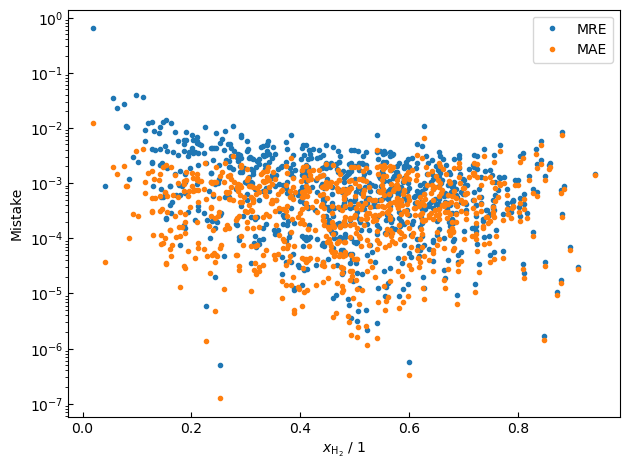

In [13]:
fig,ax = plt.subplots()
ax.semilogy(x_H2_real, abs((x_H2_pred - x_H2_real) / x_H2_real), '.', label = 'MRE')
ax.semilogy(x_H2_real, abs(x_H2_real-x_H2_pred), '.', label = 'MAE')
ax.set(xlabel = '$x \mathregular{_{H_2}}$ / 1', ylabel = 'Mistake')
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Plot Fehler vs Epoch

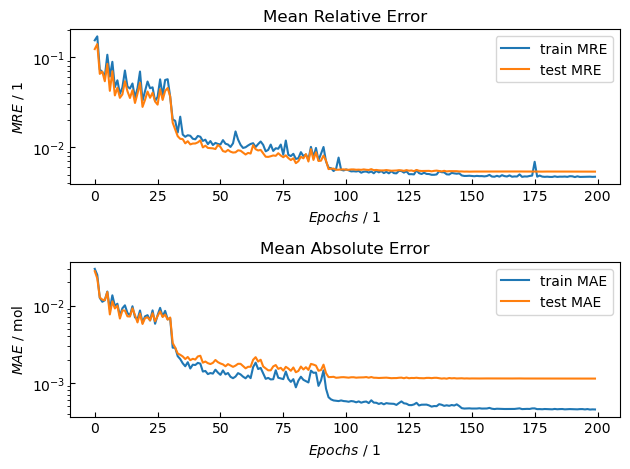

In [14]:
fig,ax = plt.subplots(2)
#fig.figsize=(12, 8)
ax[0].semilogy(train_MRE, label='train MRE')
ax[0].semilogy(test_MRE, label='test MRE')
ax[0].set_title("Mean Relative Error")
ax[0].set(xlabel = '$Epochs$ / 1', ylabel = '$MRE$ / 1') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0].legend()

ax[1].semilogy(train_MAE, label='train MAE')
ax[1].semilogy(test_MAE, label='test MAE')
ax[1].set_title("Mean Absolute Error")
ax[1].set(xlabel = '$Epochs$ / 1', ylabel = '$MAE$ / mol') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax[1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1].legend()

plt.tight_layout()
plt.show()

#### Plot Loss vs Variable Properties

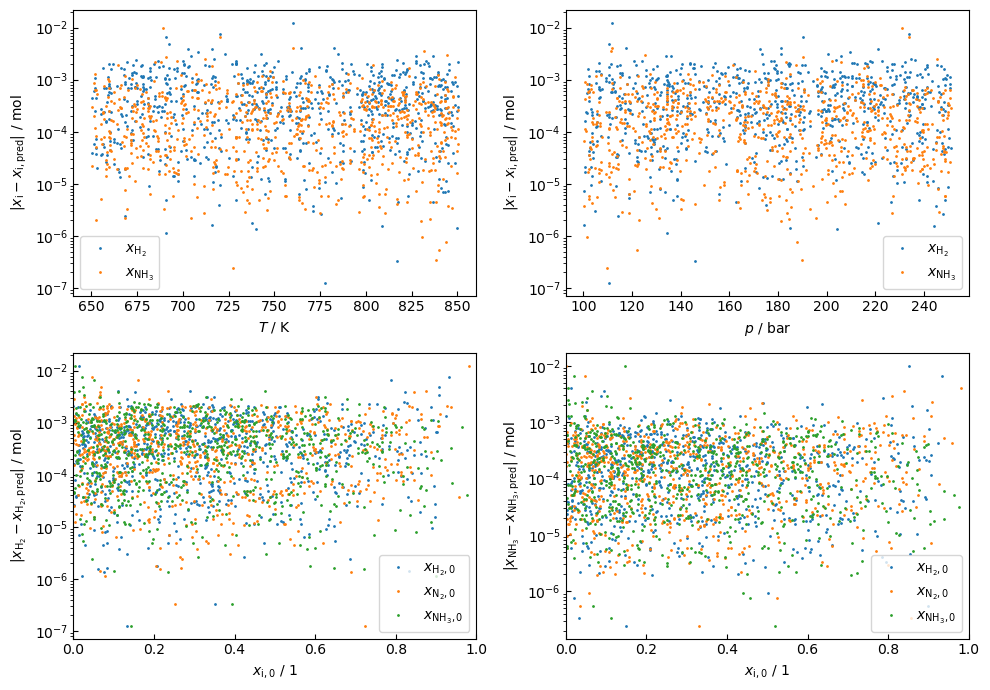

In [15]:
# mistake_H2 = []
# mistake_NH3 = []
x_H2_pred_norm = []
x_NH3_pred_norm = []
x_H2_real_norm = []
x_NH3_real_norm = []
param_T_norm = []
param_p_norm = []
param_x_H2_0_norm = []
param_x_N2_0_norm = []
param_x_NH3_0_norm = []
for X,y in train_dataloader:
#     help_mistake_H2, help_mistake_NH3 = (abs(y - net(X).detach().numpy())).T
#     mistake_H2 = np.append(mistake_H2, help_mistake_H2)
#     mistake_NH3 = np.append(mistake_NH3, help_mistake_NH3
    help_pred = net(X).detach().numpy()
    x_H2_pred_norm = np.append(x_H2_pred_norm, help_pred[:,0])
    x_NH3_pred_norm = np.append(x_NH3_pred_norm, help_pred[:,1])
    help_real = y.detach().numpy()
    x_H2_real_norm = np.append(x_H2_real_norm, help_real[:,0])
    x_NH3_real_norm = np.append(x_NH3_real_norm, help_real[:,1])
    param_T_norm = np.append(param_T_norm, X[:,0])
    param_p_norm = np.append(param_p_norm, X[:,1])
    param_x_H2_0_norm = np.append(param_x_H2_0_norm, X[:,2])
    param_x_N2_0_norm = np.append(param_x_N2_0_norm, X[:,3])
    param_x_NH3_0_norm = np.append(param_x_NH3_0_norm, X[:,4])

# print('x_H2:', x_H2_real_norm) #, x_H2_real_norm.dtype())
# print('x_H2_pred:', x_H2_pred_norm)
x_H2_pred = x_H2_pred_norm * std_out[0].numpy() + mean_out[0].numpy()
x_H2_real = x_H2_real_norm * std_out[0].numpy() + mean_out[0].numpy()
x_NH3_pred = x_NH3_pred_norm * std_out[1].numpy() + mean_out[1].numpy()
x_NH3_real = x_NH3_real_norm * std_out[1].numpy() + mean_out[1].numpy()

mistake_H2 = abs(x_H2_real - x_H2_pred)
mistake_NH3 = abs(x_NH3_real - x_NH3_pred)

param_T = param_T_norm * std_in[0].numpy() + mean_in[0].numpy()
param_p = param_p_norm * std_in[1].numpy() + mean_in[1].numpy()
param_x_H2_0 = param_x_H2_0_norm * std_in[2].numpy() + mean_in[2].numpy()
param_x_N2_0 = param_x_N2_0_norm * std_in[3].numpy() + mean_in[3].numpy()
param_x_NH3_0 = param_x_NH3_0_norm * std_in[4].numpy() + mean_in[4].numpy()

# print('T:', param_T[0])
# print(len(param_T))
# print(param_T[0])

fig,ax = plt.subplots(2,2, figsize = (10, 7)) #gridspec_kw={'width_ratios': [1,1,1,1]})

ax[0,0].semilogy(param_T, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,0].semilogy(param_T, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,0].set(xlabel = '$T$ / K', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,0].legend()

ax[0,1].semilogy(param_p, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2}}$')
ax[0,1].semilogy(param_p, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3}}$')
ax[0,1].set(xlabel = '$p$ / bar', ylabel = '|$x\mathregular{_i} - x\mathregular{_{i,pred}}$| / mol')
ax[0,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[0,1].legend()

ax[1,0].semilogy(param_x_H2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,0].semilogy(param_x_N2_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,0].semilogy(param_x_NH3_0, mistake_H2, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,0].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{H_2}} - x\mathregular{_{H_2,pred}}$| / mol')
ax[1,0].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,0].set(xlim = (0,1))
ax[1,0].legend()

ax[1,1].semilogy(param_x_H2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{H_2, 0}}$')
ax[1,1].semilogy(param_x_N2_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{N_2, 0}}$')
ax[1,1].semilogy(param_x_NH3_0, mistake_NH3, '.', markersize = 2, label = '$x\mathregular{_{NH_3, 0}}$')
ax[1,1].set(xlabel = '$x\mathregular{_{i,0}}$ / 1', ylabel = '|$x\mathregular{_{NH_3}} - x\mathregular{_{NH_3,pred}}$| / mol')
ax[1,1].tick_params(direction = 'in') #, length = 20, width = 3)
ax[1,1].set(xlim = (0,1))
ax[1,1].legend()

plt.tight_layout()
plt.show()

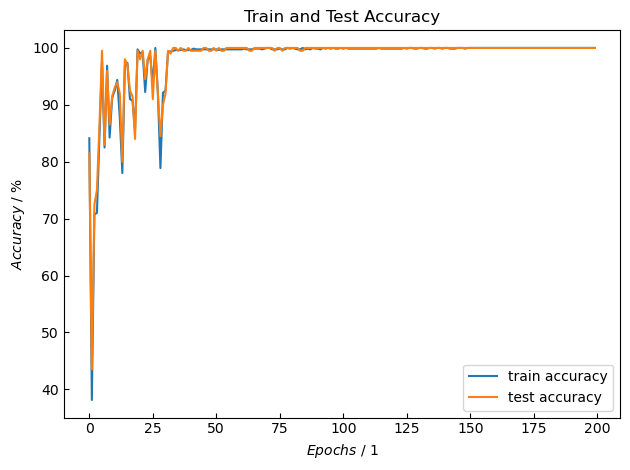

In [16]:
fig,ax = plt.subplots()
#fig.figsize=(12, 8)
ax.plot(train_accuracy, label='train accuracy')
ax.plot(test_accuracy, label='test accuracy')
plt.title("Train and Test Accuracy")
ax.set(xlabel = '$Epochs$ / 1', ylabel = '$Accuracy$ / %') #Beschriftung Achsen; Kursiv durch $$; Index durch _{}
ax.tick_params(direction = 'in') #, length = 20, width = 3)

plt.legend()
plt.tight_layout()
plt.show()

#### Debugging Hilfe

In [17]:
# Anzeigen aller Input X und Output y Daten
for (X,y) in train_dataloader:
    print(X)
    print(y)
    print(net(X))
    break

tensor([[ 9.3939e-02, -9.9426e-01, -1.2815e+00,  6.2394e-01,  6.1997e-01],
        [-1.1637e+00, -9.0495e-01,  6.9587e-01, -1.3622e+00,  7.0937e-01],
        [ 9.0888e-01,  1.6511e+00,  1.4874e+00, -4.0854e-01, -1.0422e+00],
        [-1.3192e+00,  1.5007e+00,  1.4919e-01, -1.1152e+00,  9.9342e-01],
        [ 2.4821e-01, -4.4969e-01, -1.3110e+00,  1.6663e+00, -4.1654e-01],
        [-1.7763e-01,  7.5343e-01, -5.2777e-02, -9.1972e-01,  9.9182e-01],
        [-1.5350e-01, -1.6948e+00,  1.0160e+00, -1.1813e+00,  2.1034e-01],
        [ 1.0805e+00,  1.4381e+00, -3.8197e-01,  6.1884e-01, -2.5764e-01],
        [-6.5081e-01,  1.3536e+00,  2.1032e+00, -1.2638e+00, -7.7232e-01],
        [ 1.1662e-01, -8.4935e-01, -3.6919e-01,  1.6880e+00, -1.3630e+00],
        [-1.6384e-01,  1.3188e+00, -2.3553e-02,  2.0447e-01, -1.8587e-01],
        [-3.4584e-01,  4.2744e-01, -7.6888e-01,  1.6674e+00, -9.4961e-01],
        [-6.8468e-02, -1.0068e+00, -8.0976e-01, -5.4473e-01,  1.3514e+00],
        [-1.5151e-01, -2.

#### Einblick in Netzwerk

In [18]:
list(net.parameters()) # zeigt weights, biases, ...

[Parameter containing:
 tensor([[-3.3159e-01,  2.0972e-01,  4.3826e-01, -3.1677e-01,  2.7822e-01],
         [-3.1178e-01,  9.5920e-03,  1.9890e-01,  2.3605e-01,  3.3275e-01],
         [-2.5161e-01,  1.5551e-01,  3.4222e-01, -8.8781e-02,  1.2959e-01],
         [ 6.9357e-02,  3.0759e-02, -1.8646e-01, -2.9747e-01, -6.3552e-02],
         [-3.8798e-01, -1.4032e-01,  2.3155e-01, -1.8274e-01,  2.2575e-01],
         [ 1.1114e-01, -2.0936e-01,  8.1985e-02,  3.5307e-01, -1.9806e-01],
         [-5.0114e-01,  1.4101e-01,  2.7829e-01,  1.3659e-01,  3.0442e-01],
         [-3.9130e-02,  1.1381e-01,  2.0060e-01, -8.3298e-02,  2.8268e-02],
         [ 1.6866e-01, -4.5029e-01, -3.2530e-01, -3.1161e-01, -2.6348e-01],
         [ 2.0952e-01, -1.3679e-01, -1.0214e-01,  2.0962e-01, -3.4390e-01],
         [-1.2437e-01, -1.7021e-01, -1.4615e-01,  4.0461e-01, -1.1170e-01],
         [ 1.6241e-01,  2.9824e-02,  2.9349e-01, -2.4575e-01,  2.2687e-01],
         [ 9.8299e-02, -2.4595e-01,  1.5705e-01,  4.1386e-01,  6.

In [19]:
X = torch.rand((2,5))
print(X)
print(net(X))

tensor([[0.8346, 0.4705, 0.5128, 0.2792, 0.6751],
        [0.4675, 0.8082, 0.5187, 0.8681, 0.2626]])
tensor([[ 0.4316, -0.3629],
        [-0.1238, -0.2066]], grad_fn=<AddmmBackward0>)


In [20]:
Lnorm = nn.LayerNorm(5)
Bnorm = nn.BatchNorm1d(5)

In [21]:
for (X,y) in train_dataloader:
    print(X)
    #print(y.reshape((-1,1)))
    print(Bnorm(X).mean(dim=0))
    print(Bnorm(X))
    print(Lnorm(X))
    print((Lnorm(X.permute(0,2,1))).permute(0,2,1))
    print(Lnorm(X).mean(dim=0))
    print(Lnorm(X).mean(dim=1))


    break

tensor([[ 1.5264e-01, -9.6135e-01,  1.3777e+00, -1.2424e+00, -8.2222e-02],
        [ 5.4274e-01,  9.8198e-02, -1.3514e+00,  2.0746e+00, -7.9419e-01],
        [ 1.0941e+00,  2.9172e-01, -4.5685e-02, -1.1309e+00,  1.2007e+00],
        [ 1.2845e+00, -1.6850e+00,  7.3213e-01, -1.1466e+00,  4.5340e-01],
        [-6.1863e-01, -6.0208e-01, -4.2254e-01,  2.3183e-01,  1.7773e-01],
        [-9.8495e-01,  1.4651e+00,  5.7657e-01, -5.5475e-01,  1.1575e-03],
        [-1.4028e+00, -7.5049e-01,  1.4111e+00, -6.2756e-01, -7.4338e-01],
        [-3.7241e-01,  1.2186e+00,  3.5816e-02,  1.3761e-01, -1.7580e-01],
        [ 8.4249e-01,  9.4851e-01, -2.2391e-01,  8.7501e-01, -6.7458e-01],
        [-1.0539e+00, -9.3935e-01, -5.2643e-01, -1.5918e-01,  6.7933e-01],
        [ 8.8289e-01, -9.3013e-01, -1.8951e-01, -2.5134e-01,  4.4287e-01],
        [-1.2991e-01,  7.4560e-01, -8.1336e-01, -3.3549e-02,  8.3251e-01],
        [ 3.4437e-01,  6.3322e-01, -1.2000e+00,  4.4835e-01,  7.1941e-01],
        [ 9.5982e-03, -2.

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

#### Histogramme Verteilung von $xi$ und $x{_i}$

In [ ]:
#plt.hist(xi)
plt.hist(x_0[:,0],bins=100)
plt.hist(x_0[:,1],bins=100)

plt.show()